# Arquivo de Testes

Este notebook foi criado exclusivamente para fins de testes e experimentação dos algoritmos de detecção de keypoints, matching e alinhamento de imagens. Os exemplos e funções aqui presentes servem para validar o funcionamento dos métodos e facilitar o desenvolvimento do pipeline principal.

In [2]:
import rawpy

import os, glob, re, json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Tuple

## Etapa 2 — Identificação de Keypoints
Nesta etapa, são detectados os pontos de interesse (keypoints) nas imagens usando algoritmos como SIFT, ORB ou AKAZE. Os keypoints são essenciais para encontrar correspondências entre imagens e realizar o alinhamento posterior.

In [35]:
def calcular_pontos_sift(caminho_imagem: str) -> Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]:
    """
    Recebe o caminho para uma imagem e retorna os pontos de interesse detectados usando SIFT.

    Args:
        caminho_imagem (str): Caminho para a imagem.

    Returns:
        Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]: Tupla contendo a imagem carregada, a lista de keypoints e os descritores.
    """
    imagem = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)

    # SIFT (Scale-Invariant Feature Transform) é um algoritmo para detectar e descrever pontos de interesse em imagens.
    # Parâmetros do SIFT:
    # nfeatures -> máximo de pontos de interesse, padrão é não impor limite;
    # contrastThreshold -> limite de contraste (mais alto = keypoints mais robustos), padrão é 0.04;
    # edgeThreshold -> limite de borda (mais alto = menos keypoints em bordas, que são fracos), padrão é 10;
    # sigma -> desvio padrão da Gaussian, padrão é 1.6;
    sift = cv2.SIFT_create(nfeatures=5000, contrastThreshold=0.05, edgeThreshold=20, sigma=1.6)
    keypoints, descriptors = sift.detectAndCompute(imagem, None)

    return imagem, keypoints, descriptors

In [3]:
def calcular_pontos_orb(caminho_imagem: str) -> Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]:
    """
    Recebe o caminho para uma imagem e retorna os pontos de interesse detectados usando ORB.

    Args:
        caminho_imagem (str): Caminho para a imagem.

    Returns:
        Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]: Tupla contendo a imagem carregada, a lista de keypoints e os descritores.
    """
    imagem = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
    orb = cv2.ORB_create(nfeatures=5000, scaleFactor=1.2, nlevels=8, edgeThreshold=31, firstLevel=0, WTA_K=2, scoreType=cv2.ORB_HARRIS_SCORE, patchSize=31)
    keypoints, descriptors = orb.detectAndCompute(imagem, None)
    return imagem, keypoints, descriptors

In [4]:
def calcular_pontos_akaze(caminho_imagem: str) -> Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]:
    """
    Recebe o caminho para uma imagem e retorna os pontos de interesse detectados usando AKAZE.

    Args:
        caminho_imagem (str): Caminho para a imagem.

    Returns:
        Tuple[np.ndarray, List[cv2.KeyPoint], np.ndarray]: Tupla contendo a imagem carregada, a lista de keypoints e os descritores.
    """
    imagem = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
    akaze = cv2.AKAZE_create()
    keypoints, descriptors = akaze.detectAndCompute(imagem, None)
    return imagem, keypoints, descriptors

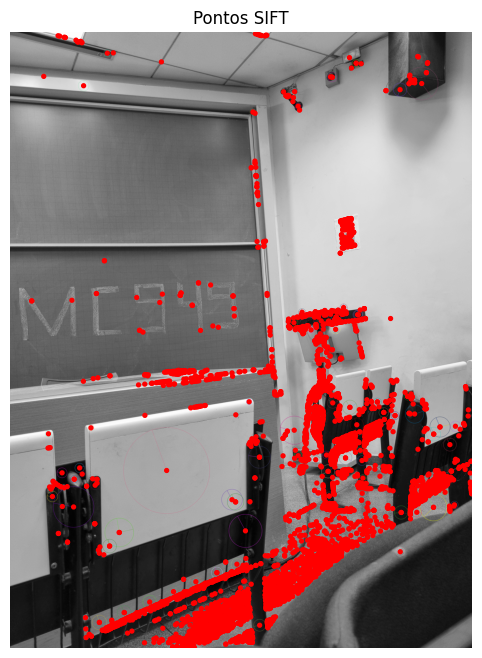

5001


In [36]:
### DETECÇÃO DE PONTOS SIFT ###

# Caminho para a imagem (substitua pelo caminho correto)
caminho_imagem = 'Jasmine - Normal - Apoio Mesa - Quadros CB11/apoioMesa1.jpg'

# Chama a função para calcular os pontos SIFT
imagem, keypoints, desc = calcular_pontos_sift(caminho_imagem)

# Destaca os pontos na imagem
imagem_com_pontos = cv2.drawKeypoints(imagem, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Mostra a imagem com os pontos destacados em uma janela
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(imagem_com_pontos, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Pontos SIFT')

# Aumenta o tamanho dos círculos dos keypoints manualmente
for kp in keypoints:
    x, y = kp.pt
    plt.gca().add_patch(plt.Circle((x, y), radius=8, color='red', fill=False, linewidth=2))

plt.show()
print(len(keypoints))  # Exibe o número de keypoints detectados

## Etapa 3 — Matching
Nesta etapa, são encontradas correspondências (matches) entre os keypoints das imagens usando algoritmos como FLANN ou Brute Force. O matching é fundamental para calcular a transformação entre as imagens.

In [37]:
def encontrar_matches_flann(
    descriptors1: np.ndarray,
    descriptors2: np.ndarray,
    ratio_test: float = 0.75
) -> List[cv2.DMatch]:
    """
    Recebe os caminhos para duas imagens, seus keypoints e descritores, e retorna os matches entre os keypoints usando FLANN.

    Args:
        caminho_imagem1 (str): Caminho para a primeira imagem.
        caminho_imagem2 (str): Caminho para a segunda imagem.
        keypoints1 (List[cv2.KeyPoint]): Keypoints da primeira imagem.
        descriptors1 (np.ndarray): Descritores da primeira imagem.
        keypoints2 (List[cv2.KeyPoint]): Keypoints da segunda imagem.
        descriptors2 (np.ndarray): Descritores da segunda imagem.
        ratio_test (float): Valor do teste de razão de Lowe (default 0.75).

    Returns:
        List[cv2.DMatch]: Lista de matches filtrados.
    """
    # FLANN parameters for SIFT/AKAZE (float descriptors)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test * n.distance:
            good_matches.append(m)
    return good_matches

In [21]:
def encontrar_matches_bruteforce(
    descriptors1: np.ndarray,
    descriptors2: np.ndarray,
    ratio_test: float = 0.75
) -> List[cv2.DMatch]:
    """
    Encontra os matches entre dois conjuntos de descritores usando o Brute Force Matcher.

    Args:
        descriptors1 (np.ndarray): Descritores da primeira imagem.
        descriptors2 (np.ndarray): Descritores da segunda imagem.
        ratio_test (float): Valor do teste de razão de Lowe (default 0.75).

    Returns:
        List[cv2.DMatch]: Lista de matches filtrados.
    """
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < ratio_test * n.distance:
            good_matches.append(m)
    return good_matches

In [22]:
# # Calcula os matches entre a imagem 001 e ela mesma usando FLANN
# matches = encontrar_matches_flann(desc, desc, ratio_test=0.75)

# # Desenha os matches entre a imagem e ela mesma
# imagem_matches = cv2.drawMatches(
#     imagem, list(keypoints),
#     imagem, list(keypoints),
#     matches, None,
#     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
# )

# plt.figure(figsize=(16, 8))
# plt.imshow(cv2.cvtColor(imagem_matches, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.title('Matches entre a imagem 001 e ela mesma usando FLANN')
# plt.show()

## Etapa 4 — Estimação de Homografia e Alinhamento
Nesta etapa, vamos calcular a homografia entre duas imagens usando RANSAC, alinhar uma imagem à outra com warpPerspective (OpenCV) e mostrar visualizações intermediárias do alinhamento.

In [ ]:
# for i in range(1, 21):

# Caminhos das imagens a alinhar
caminho_img1 = f'Jasmine - Normal - Apoio Mesa - Quadros CB11/apoioMesa1.jpg'
caminho_img2 = f'Jasmine - Normal - Apoio Mesa - Quadros CB11/apoioMesa20.jpg'

# Detecta keypoints e descritores SIFT - Etapa 2
img1, kp1, desc1 = calcular_pontos_sift(caminho_img1)
img2, kp2, desc2 = calcular_pontos_sift(caminho_img2)

# Encontra matches entre as imagens - Etapa 3
matches = encontrar_matches_flann(desc1, desc2, ratio_test=0.75)

# Seleciona os pontos correspondentes
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Calcula a homografia usando RANSAC
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
print('Homografia calculada:')
print(H)

Homografia calculada:
[[-1.85110261e+00 -5.15108781e-01  2.20163628e+03]
 [-1.31879300e+00 -1.12400001e+00  3.09152516e+03]
 [-5.36665245e-04 -3.45666130e-04  1.00000000e+00]]


## Etapa 5 — Composição e Blending

Nesta etapa, vamos compor o panorama a partir das imagens alinhadas e aplicar técnicas de blending para suavizar as transições entre elas. Por fim, avaliamos visualmente o resultado.

- Implementar a composição do panorama.
- Aplicar blending para suavizar transições (ex: feathering, linear, multiband).
- Avaliar visualmente e com métricas simples (ex: continuidade de linhas, ausência de distorções).

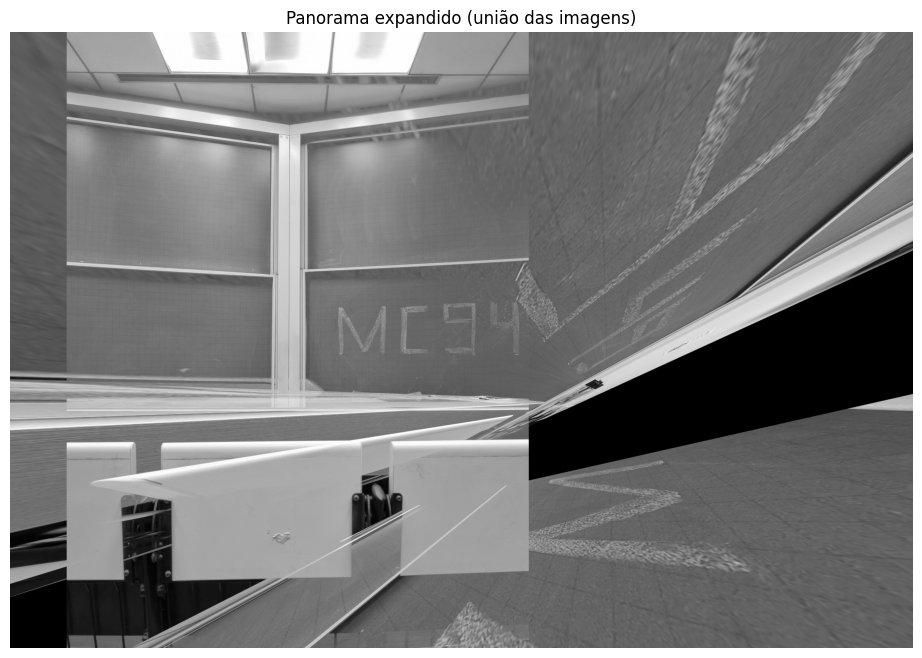

In [29]:
# Calcula os cantos das imagens 1 e 2 após a homografia
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
cantos_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
cantos_img1_warped = cv2.perspectiveTransform(cantos_img1, H)
cantos_img2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)
todos_cantos = np.concatenate((cantos_img1_warped, cantos_img2), axis=0)

[xmin, ymin] = np.int32(todos_cantos.min(axis=0).ravel())
[xmax, ymax] = np.int32(todos_cantos.max(axis=0).ravel())

# Calcula o deslocamento necessário para evitar coordenadas negativas
translacao = [-xmin, -ymin]
tamanho_panorama = (xmax-xmin, ymax-ymin)

# Matriz de translação
T = np.array([[1, 0, translacao[0]], [0, 1, translacao[1]], [0, 0, 1]])

# Warpa img1 para o panorama
img1_panorama = cv2.warpPerspective(img1, T @ H, tamanho_panorama)

# Coloca img2 no panorama
img2_panorama = np.zeros_like(img1_panorama)
img2_panorama[translacao[1]:translacao[1]+h2, translacao[0]:translacao[0]+w2] = img2

# Faz a união (overlay simples)
panorama = np.maximum(img1_panorama, img2_panorama)

plt.figure(figsize=(16, 8))
plt.imshow(panorama, cmap='gray')
plt.title('Panorama expandido (união das imagens)')
plt.axis('off')
plt.show()

# Avaliação visual: as transições entre as imagens devem estar suaves e sem linhas/distorções evidentes.

### Pipeline Completo ###

Imagem 2 alinhada e salva.
Imagem 3 alinhada e salva.
Imagem 4 alinhada e salva.
Imagem 5 alinhada e salva.
Imagem 6 alinhada e salva.
Imagem 7 alinhada e salva.
Imagem 8 alinhada e salva.
Imagem 9 alinhada e salva.
Imagem 10 alinhada e salva.
Imagem 11 alinhada e salva.
Imagem 12 alinhada e salva.
Imagem 13 alinhada e salva.
Imagem 14 alinhada e salva.
Imagem 15 alinhada e salva.
Imagem 16 alinhada e salva.
Imagem 17 alinhada e salva.
Imagem 18 alinhada e salva.
Imagem 19 alinhada e salva.
Imagem 20 alinhada e salva.
Imagem 21 alinhada e salva.
Imagem 22 alinhada e salva.
Imagem 23 alinhada e salva.
Imagem 24 alinhada e salva.
Imagem 25 alinhada e salva.
Imagem 26 alinhada e salva.
Imagem 27 alinhada e salva.
Imagem 28 alinhada e salva.
Imagem 29 alinhada e salva.
Imagem 30 alinhada e salva.


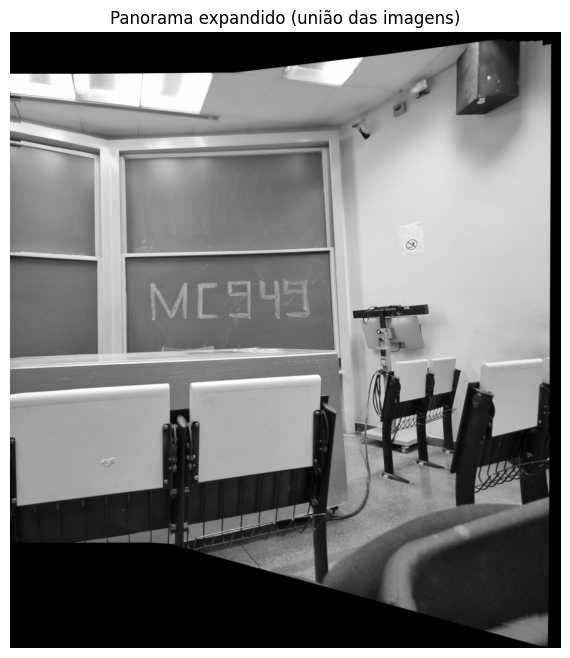

In [38]:
for i in range(1, 30):

    # Caminhos das imagens a alinhar
    caminho_img1 = f'Jasmine - Normal - Apoio Mesa - Quadros CB11/imagemFinal.jpg'
    caminho_img2 = f'Jasmine - Normal - Apoio Mesa - Quadros CB11/apoioMesa{i+1}.jpg'

    # Detecta keypoints e descritores SIFT - Etapa 2
    img1, kp1, desc1 = calcular_pontos_sift(caminho_img1)
    img2, kp2, desc2 = calcular_pontos_sift(caminho_img2)

    # Encontra matches entre as imagens - Etapa 3
    matches = encontrar_matches_flann(desc1, desc2, ratio_test=0.75)

    # Seleciona os pontos correspondentes
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Calcula a homografia usando RANSAC
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
    # print('Homografia calculada:')
    # print(H)

    # Calcula os cantos das imagens 1 e 2 após a homografia
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    cantos_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
    cantos_img1_warped = cv2.perspectiveTransform(cantos_img1, H)
    
    cantos_img2 = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)
    todos_cantos = np.concatenate((cantos_img1_warped, cantos_img2), axis=0)

    [xmin, ymin] = np.int32(todos_cantos.min(axis=0).ravel())
    [xmax, ymax] = np.int32(todos_cantos.max(axis=0).ravel())

    # Calcula o deslocamento necessário para evitar coordenadas negativas
    translacao = [-xmin, -ymin]
    tamanho_panorama = (xmax-xmin, ymax-ymin)

    # Matriz de translação
    T = np.array([[1, 0, translacao[0]], [0, 1, translacao[1]], [0, 0, 1]])

    # Warpa img1 para o panorama
    img1_panorama = cv2.warpPerspective(img1, T @ H, tamanho_panorama)

    # Coloca img2 no panorama
    img2_panorama = np.zeros_like(img1_panorama)
    img2_panorama[translacao[1]:translacao[1]+h2, translacao[0]:translacao[0]+w2] = img2

    # Faz a união (overlay simples)
    panorama = np.maximum(img1_panorama, img2_panorama)

    # Salvar o panorama sobrescrevendo imagemFinal.jpg
    cv2.imwrite('Jasmine - Normal - Apoio Mesa - Quadros CB11/imagemFinal.jpg', panorama)
    print(f'Imagem {i+1} alinhada e salva.')

plt.figure(figsize=(16, 8))
plt.imshow(panorama, cmap='gray')
plt.title('Panorama expandido (união das imagens)')
plt.axis('off')
plt.show()

In [39]:
# Limpa a imagemFinal.jpg, substituindo-a pela imagem apoioMesa1.jpg
caminho_imagem = 'Jasmine - Normal - Apoio Mesa - Quadros CB11/apoioMesa1.jpg'
cv2.imwrite('Jasmine - Normal - Apoio Mesa - Quadros CB11/imagemFinal.jpg', cv2.imread(caminho_imagem))

True